In [1]:
import sys
# sys.path.append("/Users/cosinga/code/pkthunder/io/")
sys.path.append("/Users/cosinga/software/illustris_python/")
sys.path.append('/Users/cosinga/software/colossus/')



import numpy as np
import matplotlib.pyplot as plt


In [25]:
import illustris_python as il
import numpy as np
from typing import Union

class TNGLoader(object):

    _def_simnames = [
        'tng100',
        'tng300',
        'Mtng'
    ]

    def __init__(self, 
        path : str,
        simname : str,
        snap : int
    ) -> None:
        self.path = path
        if simname not in self._def_simnames:
            msg = "not an implemented simulation name\n"
            msg += "accepted simnames: " + str(self._def_simnames)
            raise NotImplementedError(msg)
        
        self.simname = simname
        self.snap = snap

        self.loadGal()

        return
    

    def loadGal(self) -> None:
        path = self.path
        snap = self.snap

        sfields = [
            'SubhaloMassType',
            'SubhaloMass',
            'SubhaloGrNr',
            'SubhaloStellarPhotometrics',
            'SubhaloPos'
        ]

        gfields = [
            'GroupFirstSub',
            'GroupPos',
            'Group_M_Mean200',
            'Group_R_Mean200'
        ]
        self.head = il.groupcat.loadHeader(path, snap)
        h = self.head['HubbleParam']
        sdata = il.groupcat.loadSubhalos(path, snap, sfields)
        hdata = il.groupcat.loadHalos(path, snap, gfields)
        ngals = sdata[sfields[0]].shape[0]
        
        # label which galaxies are centrals
        is_cent = np.zeros(ngals, dtype = bool)
        is_cent[hdata['GroupFirstSub']] = True

        # save the host data for each galaxy
        host_mass = np.zeros_like(sdata['SubhaloMass'])
        host_pos = np.zeros((host_mass.shape[0], 3))
        host_rad = np.zeros_like(host_mass)
        host_mass = hdata['Group_M_Mean200'][sdata['SubhaloGrNr']]
        host_pos = hdata['GroupPos'][sdata['SubhaloGrNr'], :]
        host_rad = hdata['Group_R_Mean200'][sdata['SubhaloGrNr']]
        # calculate g - r
        photo = sdata['SubhaloStellarPhotometrics']
        gr = photo[:, 4] - photo[:, 5]
        
        # save arrays
        self.gdata = {
            'stmass' : sdata['SubhaloMassType'][:, 4] * 1e10/h,
            'total_mass' : sdata['SubhaloMass'] * 1e10/h,
            'is_central' : is_cent,
            'host_mass' : host_mass * 1e10/h,
            'gr' : gr,
            'host_x' : host_pos / 1e3,
            'x' : sdata['SubhaloPos'] / 1e3,
            'host_r' : host_rad / 1e3 * self.head['Time'],
            'host_idx' : sdata['SubhaloGrNr']
        }

        self.hdata = {
            'mass' : hdata['Group_M_Mean200'] * 1e10 / h
        }
        return
    
    def loadHI() -> None:
        return
    
    # data getters

    def getBox(self):
        # convert to Mpc / h
        return self.head['BoxSize'] / 1e3
    
    def getHaloMass(self):
        return self.hdata['mass'].copy()
        
    def getGalMass(self):
        return self.gdata['stmass'].copy()

    def getZ(self):
        return self.head['Redshift']
    
    def getResolvedGalMask(self):
        if self.simname == 'tng100':

            return self.gdata['stmass'] > 2e8
        else:
            raise NotImplementedError(
                'resolution definitions for other sims not defined'
            )
        
    def _getGRCut(self):
        if self.snap == 99:
            return 0.60
        elif self.snap == 67:
            return 0.55
        elif self.snap == 50:
            return 0.5
        else:
            raise NotImplementedError(
                'No GR Cut defined for snapshot {:d}'.format(self.snap)
            )
    
    def getBlueMask(self):
        grcut = self._getGRCut()
        return self.gdata['gr'] <= grcut
    
    def getCentralMask(self):
        return self.gdata['is_central'].copy()
    
    

In [26]:
TNGPATH = '/Users/cosinga/sims/illustris/L75n1820TNG/output/'

tngloads = [TNGLoader(TNGPATH, 'tng100', 99), TNGLoader(TNGPATH, 'tng100', 67)]


[]

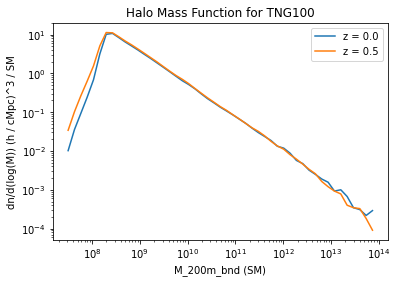

In [27]:
for tngl in tngloads:
    hmass = tngl.getHaloMass()
    box = tngl.getBox()
    z = tngl.getZ()
    log_hmass = np.log10(hmass[hmass > 0])
    mass_min = 7.5; mass_max = 14; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_hmass, bins)
    hist = hist / (box) ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))
plt.title('Halo Mass Function for TNG100')
plt.legend()
plt.xlabel('M_200m_bnd (SM)')
plt.ylabel('dn/d(log(M)) (h / cMpc)^3 / SM')
plt.loglog()


[]

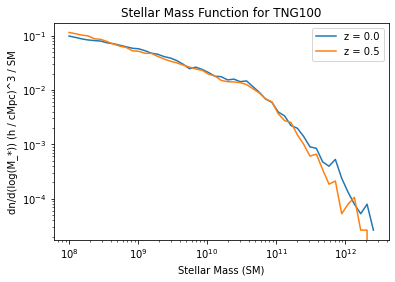

In [28]:
for tngl in tngloads:
    stmass = tngl.getGalMass()
    box = tngl.getBox()
    z = tngl.getZ()
    log_stmass = np.log10(stmass[stmass > 0])
    mass_min = 8; mass_max = 12.5; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_stmass, bins)
    hist = hist / box ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))
plt.loglog()
plt.legend()
plt.title('Stellar Mass Function for TNG100')
plt.xlabel('Stellar Mass (SM)')
plt.ylabel('dn/d(log(M_*)) (h / cMpc)^3 / SM')
plt.loglog()

[]

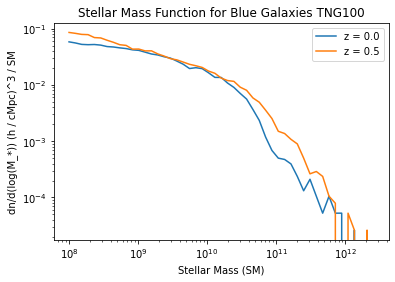

In [29]:
for tngl in tngloads:
    stmass = tngl.getGalMass()
    box = tngl.getBox()
    z = tngl.getZ()
    blue_mask = tngl.getBlueMask()
    log_stmass = np.log10(stmass[(stmass > 0) & blue_mask])
    mass_min = 8; mass_max = 12.5; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_stmass, bins)
    hist = hist / box ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))

plt.loglog()
plt.legend()
plt.title('Stellar Mass Function for Blue Galaxies TNG100')
plt.xlabel('Stellar Mass (SM)')
plt.ylabel('dn/d(log(M_*)) (h / cMpc)^3 / SM')
plt.loglog()

[]

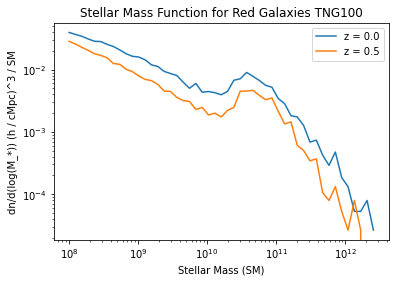

In [30]:
for tngl in tngloads:
    stmass = tngl.getGalMass()
    box = tngl.getBox()
    z = tngl.getZ()
    blue_mask = tngl.getBlueMask()
    log_stmass = np.log10(stmass[(stmass > 0) & ~blue_mask])
    mass_min = 8; mass_max = 12.5; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_stmass, bins)
    hist = hist / box ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))

plt.loglog()
plt.legend()
plt.title('Stellar Mass Function for Red Galaxies TNG100')
plt.xlabel('Stellar Mass (SM)')
plt.ylabel('dn/d(log(M_*)) (h / cMpc)^3 / SM')
plt.loglog()

[]

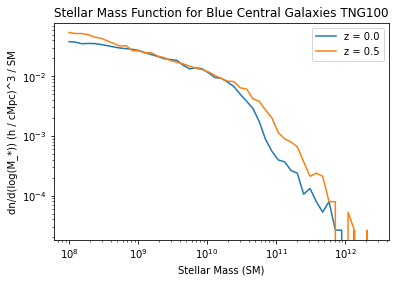

In [31]:
for tngl in tngloads:
    stmass = tngl.getGalMass()
    box = tngl.getBox()
    z = tngl.getZ()
    blue_mask = tngl.getBlueMask()
    cen_mask = tngl.getCentralMask()
    log_stmass = np.log10(stmass[(stmass > 0) & blue_mask & cen_mask])
    mass_min = 8; mass_max = 12.5; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_stmass, bins)
    hist = hist / box ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))

plt.loglog()
plt.legend()
plt.title('Stellar Mass Function for Blue Central Galaxies TNG100')
plt.xlabel('Stellar Mass (SM)')
plt.ylabel('dn/d(log(M_*)) (h / cMpc)^3 / SM')
plt.loglog()

[]

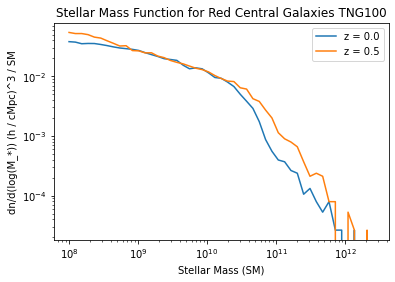

In [16]:
for tngl in tngloads:
    stmass = tngl.getGalMass()
    box = tngl.getBox()
    z = tngl.getZ()
    blue_mask = tngl.getBlueMask()
    cen_mask = tngl.getCentralMask()
    log_stmass = np.log10(stmass[(stmass > 0) & ~blue_mask & cen_mask])
    mass_min = 8; mass_max = 12.5; nbins = 50

    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hist, edges = np.histogram(log_stmass, bins)
    hist = hist / box ** 3 / bin_width

    plt.plot(10**edges[:-1], hist, label = 'z = {:.1f}'.format(z))

plt.loglog()
plt.legend()
plt.title('Stellar Mass Function for Red Central Galaxies TNG100')
plt.xlabel('Stellar Mass (SM)')
plt.ylabel('dn/d(log(M_*)) (h / cMpc)^3 / SM')
plt.loglog()

Text(0, 0.5, '<N_cen> (M)')

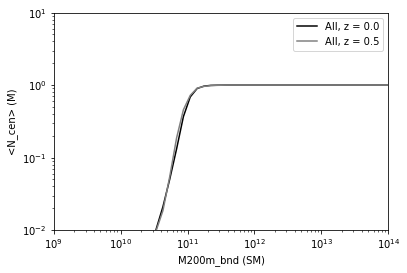

In [35]:
# central galaxy occupation of halos
i = 0
all_cols = ['black', 'gray']
blue_cols = ['darkblue', 'blue']
red_cols = ['darkred', 'red']
for tngl in tngloads:
    res_mask = tngl.getResolvedGalMask()
    cen_mask = tngl.getCentralMask()
    blue_mask = tngl.getBlueMask()

    hmass = tngl.getHaloMass()
    box = tngl.getBox()
    z = tngl.getZ()
    log_hmass = np.log10(hmass[hmass > 0])
    mass_min = 9; mass_max = 14; nbins = 50
    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins
    hmass_hist, edges = np.histogram(log_hmass, bins = bins)
    hmass_hist = hmass_hist / box ** 3 / bin_width
    
    

    # assume that all centrals occupy different halos
    host_mass = np.log10(tngl.gdata['host_mass'][cen_mask & res_mask])
    cen_occ, edges = np.histogram(host_mass, bins = bins)
    cen_occ = cen_occ / box ** 3 / bin_width
    occ_frac = cen_occ / hmass_hist
    plt.plot(10**edges[1:], occ_frac, label = "All, z = {:.1f}".format(z), color = all_cols[i])
    

    
    
    
    
    i += 1

plt.loglog()
plt.legend()
plt.ylim(1e-2, 10)
plt.xlim(1e9, 1e14)
plt.xlabel('M200m_bnd (SM)')
plt.ylabel('<N_cen> (M)')
    
    

Text(0, 0.5, '<N_cen> (M)')

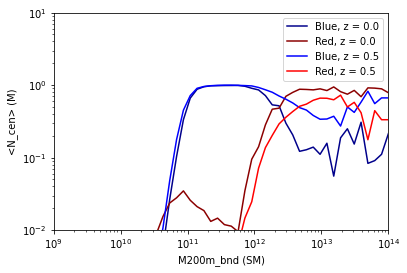

In [36]:
# central galaxy occupation of halos
i = 0
blue_cols = ['darkblue', 'blue']
red_cols = ['darkred', 'red']
for tngl in tngloads:
    res_mask = tngl.getResolvedGalMask()
    cen_mask = tngl.getCentralMask()
    blue_mask = tngl.getBlueMask()

    hmass = tngl.getHaloMass()
    box = tngl.getBox()
    z = tngl.getZ()

    log_hmass = np.log10(hmass[hmass > 0])
    hmass_hist, edges = np.histogram(log_hmass, bins = bins)
    hmass_hist = hmass_hist / box ** 3 / bin_width
    mass_min = 9; mass_max = 14; nbins = 50
    bins = np.linspace(mass_min, mass_max, nbins)
    bin_width = (mass_max - mass_min) / nbins

    
    blue_hosts = np.log10(tngl.gdata['host_mass'][cen_mask & blue_mask & res_mask])
    bl_occ, _ = np.histogram(blue_hosts, bins = bins)
    bl_occ = bl_occ / box ** 3 / bin_width
    bl_occ_frac = bl_occ / hmass_hist
    plt.plot(10**edges[1:], bl_occ_frac, label = "Blue, z = {:.1f}".format(z), color = blue_cols[i])

    red_hosts = np.log10(tngl.gdata['host_mass'][cen_mask & ~blue_mask & res_mask])
    rd_occ, _ = np.histogram(red_hosts, bins = bins)
    rd_occ = rd_occ / box ** 3 / bin_width
    rd_occ_frac = rd_occ / hmass_hist
    plt.plot(10**edges[1:], rd_occ_frac, label = "Red, z = {:.1f}".format(z), color = red_cols[i])

    
    
    
    
    i += 1

plt.loglog()
plt.legend()
plt.ylim(1e-2, 10)
plt.xlim(1e9, 1e14)
plt.xlabel('M200m_bnd (SM)')
plt.ylabel('<N_cen> (M)')

    